In [1]:
import tensorflow as tf
import os

2022-09-16 22:11:32.740704: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Getting rid of incompatible images

In [2]:
import cv2
import imghdr

In [3]:
dataDir = 'data'

In [4]:
imageExts = ['jpeg', 'jpg', 'bmp', 'png']

In [5]:
for dataClass in os.listdir(dataDir):
    if os.path.isdir(dataClass):
        for dataPoint in os.listdir(os.path.join(dataDir, dataClass)):
            dataPath = os.path.join(dataDir, dataClass, dataPoint)
            try:
                image = cv2.imread(dataPath)
                extn = imghdr.what(dataPath)
                if extn not in imageExts:
                    print('Incompatible file type {}'.format(dataPath))
                    os.remove(dataPath)
            except Exception as e:
                print('Error in reading image {}'.format(dataPath))
                os.remove(dataPath)

## Loading Data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

In [7]:
#Creating a dataset from the data directory using a keras helper
data = tf.keras.utils.image_dataset_from_directory(dataDir)

Found 164 files belonging to 2 classes.


2022-09-16 22:11:39.591444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#Creating a numpy iterator from the dataset
dataIterator = data.as_numpy_iterator()

In [9]:
#Getting batches of 32 datapoints using the iterator
batch = dataIterator.next()

In [10]:
#Each batch has an array of datapoints(images) and their respective class labels
batch[0].shape, batch[1].shape

((32, 256, 256, 3), (32,))

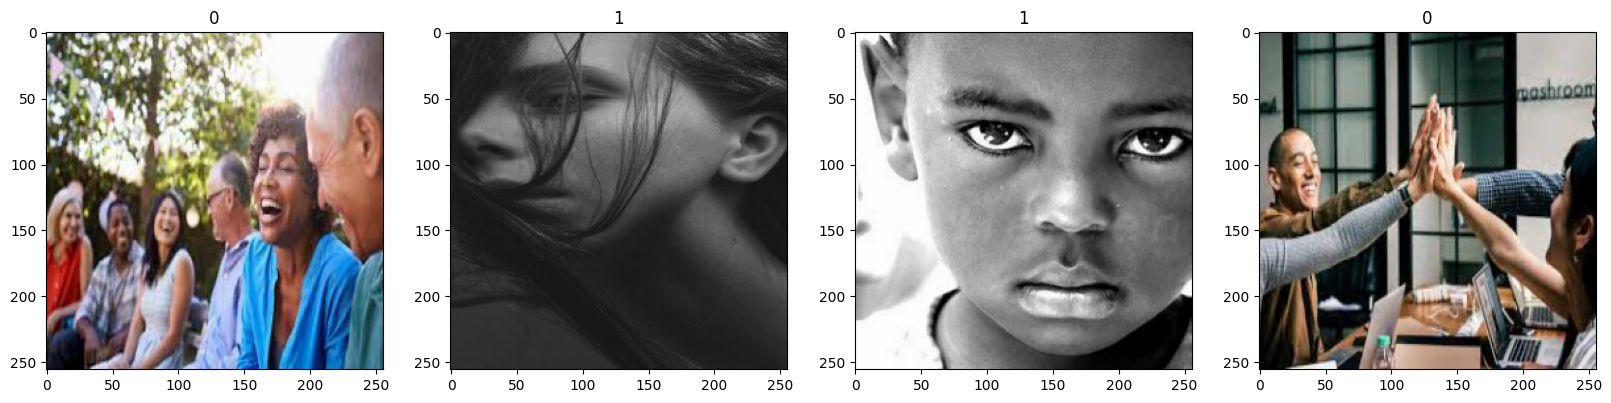

In [11]:
#Making sample plots from the batch of data to check which label corresponds to which class
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above, 1 corresponds to sad and 0 corresponds to happy.

## Preprocessing the data

Scaling the data by normalizing all values between 0 and 1 will optimise model's learning.

In [12]:
#Applying transformations on the image data using a lambda function
data = data.map(lambda x,y: (x/255,y))

In [13]:
scaledIterator = data.as_numpy_iterator()
batch = scaledIterator.next()

Splitting the data into training, validation and test sets in a 70:20:10 ratio:

In [14]:
#Rounding up/rounding down split sizes to match up with the total number of batches
import math
train_size = math.floor(len(data)*.7)
val_size = math.floor(len(data)*.2)
test_size = math.ceil(len(data)*.1)

In [15]:
#Checking if the split sizes match up
len(data), train_size, val_size, test_size

(6, 4, 1, 1)

In [16]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Building the Deep Learning Model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [18]:
model = Sequential()

In [19]:
#Adding layers
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #input layer
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## Training the Model

In [22]:
logDir = 'logs'

In [23]:
tensorboardCallback = tf.keras.callbacks.TensorBoard(log_dir=logDir)

In [24]:
#Fitting the model
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboardCallback])

Epoch 1/20
4/4 [==============================] - 6s 1s/step - loss: 1.0304 - accuracy: 0.5703 - val_loss: 0.7295 - val_accuracy: 0.3750
Epoch 2/20
4/4 [==============================] - 5s 983ms/step - loss: 0.6520 - accuracy: 0.5312 - val_loss: 0.5445 - val_accuracy: 0.6562
Epoch 3/20
4/4 [==============================] - 5s 994ms/step - loss: 0.5248 - accuracy: 0.7188 - val_loss: 0.4253 - val_accuracy: 0.8438
Epoch 4/20
4/4 [==============================] - 5s 993ms/step - loss: 0.4963 - accuracy: 0.7422 - val_loss: 0.5146 - val_accuracy: 0.6250
Epoch 5/20
4/4 [==============================] - 5s 1s/step - loss: 0.4438 - accuracy: 0.7812 - val_loss: 0.4121 - val_accuracy: 0.9375
Epoch 6/20
4/4 [==============================] - 5s 1s/step - loss: 0.4319 - accuracy: 0.9297 - val_loss: 0.3938 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 6s 1s/step - loss: 0.3356 - accuracy: 0.9062 - val_loss: 0.2539 - val_accuracy: 0.9375
Epoch 8/20
4/4 [================

## Plotting Performance

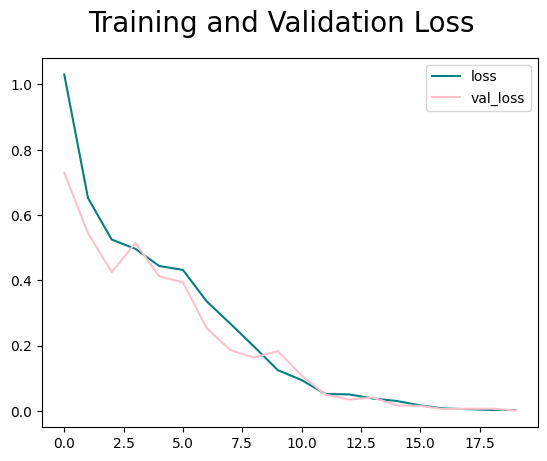

In [25]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='pink', label='val_loss')
fig.suptitle('Training and Validation Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

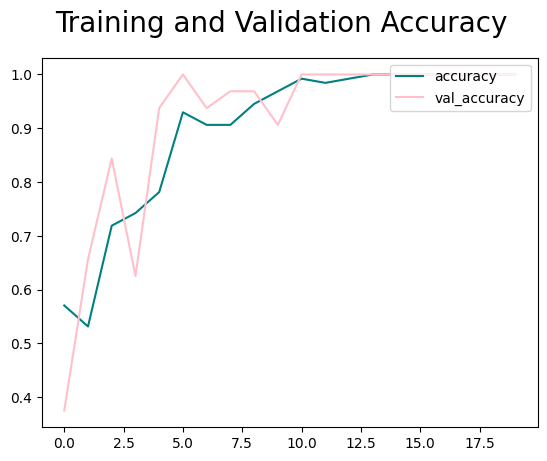

In [26]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='pink', label='val_accuracy')
fig.suptitle('Training and Validation Accuracy', fontsize=20)
plt.legend(loc='upper right')
plt.show()

## Evaluating Model Performance

In [27]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre, re, acc = Precision(), Recall(), BinaryAccuracy()

In [28]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 134ms/step


In [29]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## Testing with random images

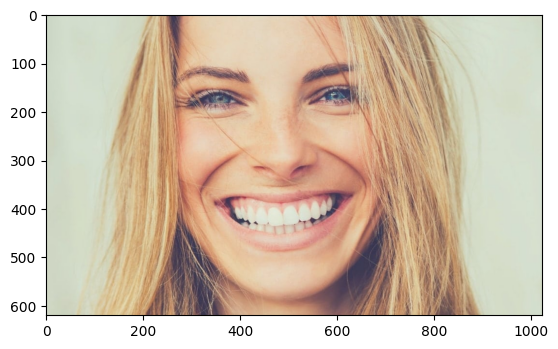

In [43]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

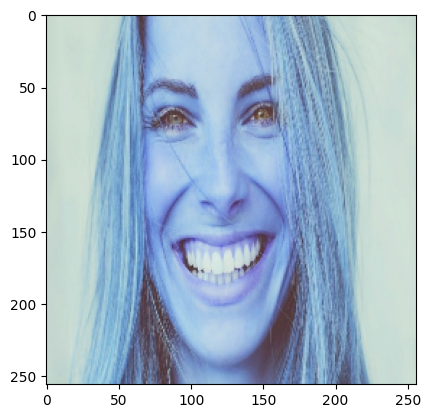

In [44]:
resizedImg = tf.image.resize(img, (256,256))
plt.imshow(resizedImg.numpy().astype(int))
plt.show()

In [45]:
yhat = model.predict(np.expand_dims(resizedImg/255, 0))

1/1 [==============================] - 0s 36ms/step


In [47]:
if(yhat<0.5):
    print('Predition: Happy')
else:
    print('Prediction: Sad')

Predition: Happy


## Saving the Model

In [50]:
model.save(os.path.join('models', 'sentimentclassifier.h5'))